# 08-PSF Extraction

From ginga, you have to find the FWHM of the stars.

1. Open ginga
2. ``Operation`` --> ``FBrowser`` --> open your FITS file (Here, ``SNUO_STX16803-M11-1-1-20190507-171622-V-60.0.fits``)
3. ``Operation`` --> ``Analysis`` --> ``Pick``
4. Find a star that is (1) not overlap with other (2) bright enough but not saturated. They are not at the center of the image.
5. left click and right click to do "pick" ([See official documentation of Pick](https://ginga.readthedocs.io/en/stable/manual/plugins_local/pick.html))
6. Bottom right panel: ``Settings`` --> set ``Radius`` to 25 pix (since SNUO 1m has too small pixel scale...)
7. Click ``Redo Pick``
8. Top right panel: Select ``Radial``.
9. Check if it is good:
![](figs/psfpick.png)
10. If not good, select different star.
11. Bottom right panel: ``Report`` --> ``Add Pick``
12. Do this for around 10 stars throughout the image (better if regularly spaced).
13. ``Save table`` with ``.csv`` extension.

From this process, you will see FWHM is roughly 12-13 pixels. I just used 12 pixel, since it is not important to achieve accurate number.

In [1]:
fwhm = 12
psf_size = fwhm * 4 + 1

In [2]:
from pathlib import Path
from photutils import DAOStarFinder
from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.centroids import centroid_com

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter

from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize, LinearStretch
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.nddata import CCDData, Cutout2D
import astroscrappy

from scipy.interpolate import RectBivariateSpline

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

plt.style.use('default')
rcParams.update({'font.size':12})
LACOSMIC_KEYS = dict()

def znorm(image, stretch=LinearStretch(), **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs), stretch=stretch)


def zimshow(ax, image, stretch=LinearStretch(), **kwargs):
    return ax.imshow(image, norm=znorm(image, stretch=stretch, **kwargs), origin='lower')

def colorbaring(fig, ax, im, fmt="%d"):
    cb = fig.colorbar(im, ax=ax, orientation='horizontal', format=FormatStrFormatter(fmt))
    return cb
    
DATAPATH = Path("../data")
LOGPATH = Path("./tmp")

In [3]:
hdul = fits.open(DATAPATH / "SNUO_STX16803-M11-1-1-20190507-171622-V-60.0.fits")
print(hdul.info())
data_raw = hdul[0].data#[2000:3000,1000:2000]

gain = hdul[0].header["GAIN"]
readnoise = hdul[0].header["RDNOISE"]

Filename: ../data/SNUO_STX16803-M11-1-1-20190507-171622-V-60.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      73   (4096, 4096)   float32   
None


## CR Rejection
CR rejection is essential for PSF photometry.

In [4]:
crpath = LOGPATH / "SNUO_STX16803-M11-1-1-20190507-171622-V-60.0_CR.fits"
try:
    ccd = CCDData.read(LOGPATH/"SNUO_STX16803-M11-1-1-20190507-171622-V-60.0_CR.fits")
    data = ccd.data
except FileNotFoundError:
    _, data = astroscrappy.detect_cosmics(data_raw,
                                      sepmed=True,  # IRAF LACosmic is sepmed=False
                                      gain=gain,
                                      readnoise=readnoise,
                                      verbose=True,
                                      sigclip=4.5, 
                                      sigfrac=0.5,
                                      objlim=5.0,
                                      satlevel=np.inf, 
                                      pssl=0.0, 
                                      niter=4,
                                      cleantype='medmask', 
                                      fsmode='median', 
                                      psfmodel='moffat',
                                      psffwhm=fwhm,
                                      psfsize=fwhm*3, 
                                      psfk=None, 
                                      psfbeta=4.765)
    # astroscrappy by default does the gain correction...
    data /= gain
    ccd = CCDData(data=data, header=hdul[0].header, unit='adu')
    ccd.write(LOGPATH/"SNUO_STX16803-M11-1-1-20190507-171622-V-60.0_CR.fits")

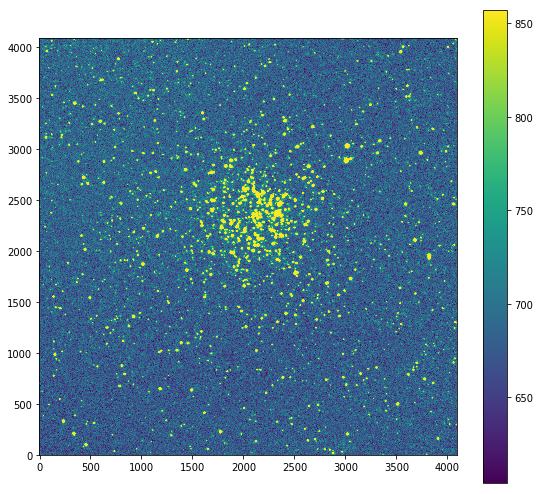

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
im = zimshow(ax, ccd.data)
plt.colorbar(im)
plt.tight_layout()

## Load the ``Pick`` Result

Load the ginga ``Pick`` results, and find the centers of the stars. 

In [6]:
pick_colnames = ["background", "brightness", "dec_deg", "dec_txt", "ellipse", 
                 "equinox", "fwhm", "fwhm_x", "fwhm_y", "ra_deg", "ra_txt", 
                 "skylevel", "starsize", "time_local", "time_ut", "x", "y"]

pick = Table.read(LOGPATH / "pick_log.txt", format="ascii.csv", 
                  delimiter=' ', data_start=2, comment="#", names=pick_colnames)
# NOTE: ginga pick has 1-indexing: https://github.com/ejeschke/ginga/issues/769
pick["x"] -= 1
pick["y"] -= 1

# Only pixels near the stars in the txt file
mask = np.ones_like(data).astype(bool)
for row in pick:
    pos = (row["x"], row["y"])
    iy, ix = Cutout2D(mask, position=pos, size=psf_size).bbox_original
    mask[iy[0]:iy[1], ix[0]:ix[1]] = False

thresh = np.median(data)

finder = DAOStarFinder(fwhm=fwhm, threshold=thresh, exclude_border=True)
found = finder(data, mask=mask)
print(f"Stars initially selected for the PSF estimation: {len(pick)}")
if len(pick) != len(found):
    print("!!!!!! pick and found length not match !!!!!!")

found.remove_columns(["npix", "sky"]) # remove confusing columns from DAOStarFinder

Stars initially selected for the PSF estimation: 11


* **NOTE**: You may note that this is extraordinarily slow. The reason is that the ``DAOStarFinder`` calculates convolution, etc, to all the image, although we input ``mask``. For faster calculation, you may use some workaround, e.g., cut the CCD near the star (using ``astropy.nddata.Cutout2D``) and do convolution and centroiding. 

## Crop the Pixels Near the PSF Stars
Crop the image by ``psf_size`` box centering on the PSF stars:

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,peak,flux,mag,x_init,y_init,shift,msky,ssky,nsky,nrej,source_sum
int64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object
1,238.85115298969512,332.34054256203666,0.4401241929719524,-0.03943707016586912,-0.07215727091390467,4152.99755859375,12.441593154820005,-2.7371899890795675,238.905523560461,332.3198463790802,0.05817637797572497,673.521240234375,24.589237,9022,26,698141.7875201656
2,1496.6074222277455,637.159707466627,0.4136375425656173,-0.03860477637959083,-0.08514861257548587,3088.848388671875,8.81422621853042,-2.36296048138628,1496.5788988424601,637.077528720268,0.08698810183736745,676.5090942382812,25.537466,8867,184,502256.82397753303
3,3682.742042915698,2106.891043363325,0.4185455339672266,-0.003622443501840364,-0.11195325163302039,6810.59228515625,22.018596329255114,-3.3569740738407514,3682.80214617801,2106.8299378147226,0.08571050233497764,682.3922729492188,29.630915,8325,727,1279201.6518013373
4,415.87615569844763,2149.1165592225652,0.4198781512888808,-0.021708800774318186,-0.06664486780980042,1785.2357177734375,4.043721177000639,-1.516953006105085,415.97307079270826,2149.0988273228963,0.09852388421805666,684.9557495117188,25.356514,8993,47,217473.64773964207
5,3591.7323929487766,2460.19371619969,0.42216813773485184,-0.0023659169697568642,-0.1393537957458511,4218.8671875,12.72102841499816,-2.7613055567606475,3591.739485512434,2460.0978895148974,0.09608880256065694,681.6400146484375,25.988544,9003,50,740031.3990296747
6,802.4228800194602,2468.0570449646843,0.43839032826659835,-0.019952395851957804,-0.07477903194877465,3661.12890625,10.984251048569458,-2.6019261257034043,802.4017254924273,2468.025660111085,0.03784868623130116,686.0252685546875,24.965832,8970,79,574740.8284627779
7,3738.8410675571527,2961.258331866712,0.42351458363868594,-0.016173420587096837,-0.11400323443184089,8811.4462890625,29.076985655465524,-3.658873455514619,3738.851589770518,2961.212814804096,0.046717448167596515,681.4129028320312,26.016148,9007,46,1706028.0142817767
8,601.0607143750029,3271.0039486492724,0.4416912018551543,-0.0245725838509722,-0.061755936404042616,4489.91455078125,13.893232883597387,-2.8570082889552335,601.1217260630787,3270.9889764592895,0.06282191142216398,686.5735473632812,27.007498,8669,366,735296.3041671645
9,1614.46198102762,3292.0492591222196,0.4304475156616639,-0.03309135390395466,-0.11120756919086931,2290.906494140625,5.801674178631397,-1.9088833380557135,1614.4729059873664,3292.034845926474,0.01808576669810234,683.3761596679688,25.951788,8381,666,326749.7424618481


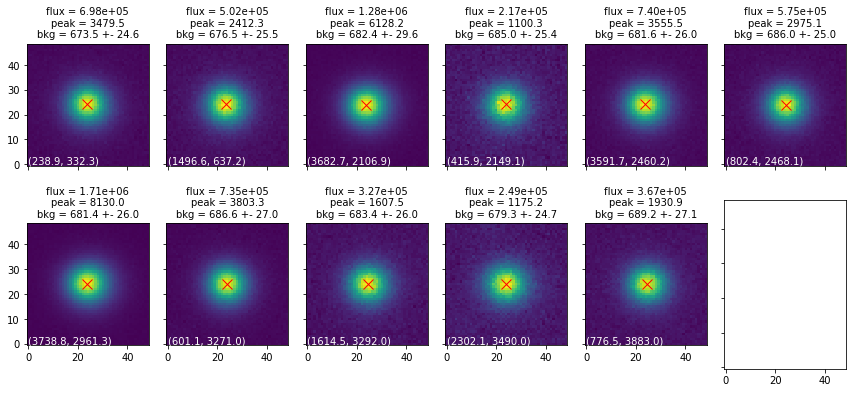

In [7]:
cut4psf = []

ncol = 6
nrow = max(len(found) // ncol + 1, 1)
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 2.8 * nrow), sharex=True, sharey=True)

r_ap = 2 * fwhm
r_in = 4 * fwhm
r_out = 6 * fwhm

# Initialize columns
for c in ["x_init", "y_init", "shift", "msky", "ssky", "nsky", "nrej", "source_sum"]:
    found[c] = None
    
for i, row in enumerate(found):
    matchpick = pick[(abs(pick["x"] - row["xcentroid"]) < 5)
                    & (abs(pick["y"] - row["ycentroid"]) < 5)]    
    row["x_init"] = matchpick["x"][0]
    row["y_init"] = matchpick["y"][0]
    row["shift"] = np.sqrt((row["xcentroid"] - row["x_init"])**2 
                                + (row["ycentroid"] - row["y_init"])**2)
    pos = (row["xcentroid"], row["ycentroid"])
    ap = CAp(positions=pos, r=r_ap)
    an = CAn(positions=pos, r_in=r_in, r_out=r_out)
    phot = ypu.apphot_annulus(ccd=ccd, aperture=ap, annulus=an, 
                              sky_keys=dict(mode_option="MMM"))
    for c in ["msky", "ssky", "nsky", "nrej", "source_sum"]:
        row[c] = phot[c][0]

    # Figure plotting
    irow = i // ncol
    icol = i - irow * ncol
    ax = axs[irow, icol]
    pos = (row["xcentroid"], row["ycentroid"])

    cut_orig = Cutout2D(ccd.data, position=pos, size=psf_size)
    cut_skysub = Cutout2D(ccd.data, position=pos, size=psf_size)
    cut_skysub_norm = Cutout2D(ccd.data, position=pos, size=psf_size)
    
    cut_skysub.data = (cut_orig.data - row["msky"])
    cut_skysub_norm.data = cut_skysub.data / row["source_sum"]
    cut4psf.append(cut_skysub)

    peak_skysub = cut_skysub.data.max()
    posstr = f"({row['xcentroid']:.1f}, {row['ycentroid']:.1f})"
    
    # For showing bright star for PSF, it's better to set high vmin, not zscale,
    # because the central structure near the star cneter is important.
    ax.imshow(cut_skysub.data, origin='lower')
#     zimshow(ax, cut.data)
    ax.text(0, 0, posstr, fontsize=10, color='w')
    ax.set_title(f"flux = {row['source_sum']:.2e}\n"
                 + f"peak = {peak_skysub:.1f}\n"
                 + f"bkg = {row['msky']:.1f} +- {row['ssky']:.1f}",
                fontsize=10)
    ax.plot(*cut_orig.to_cutout_position(pos), 'rx', ms=10)
    
plt.tight_layout()

found.write(LOGPATH / "psf_01.csv", overwrite=True)
found

## Interpolation to PSF Stars
We do interpolation to each star, and oversample by factor of 4. 

* **NOTE**: In Stetson's original paper, he used Gaussian and spline hybrid model, but I couldn't see any gain from using it. I cannot understand why we can say we have better accuracy if we use hybrid model (Eq 7 of the paper). If you think it is important, you may use that. The integrated Gaussian function is available from photutils as [``photutils.psf.IntegratedGaussianPRF``](https://photutils.readthedocs.io/en/stable/api/photutils.psf.IntegratedGaussianPRF.html#photutils.psf.IntegratedGaussianPRF).

Here I just did the 2-D bicubic spline interpolation:

/Users/ysbach/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log10


Statistics of the final psf image
N         : 37249
min       : -2.5802140287325856e-06
max       : 0.00030414922223241496
avg       : 2.6846358291497755e-05
med       : 5.081764340651352e-06
std       : 5.2390446085912626e-05
percentiles: [-8.06302124e-07  2.61025930e-04]
zmin      : -1.4621209396411887e-06
zmax      : 7.337727737823117e-05


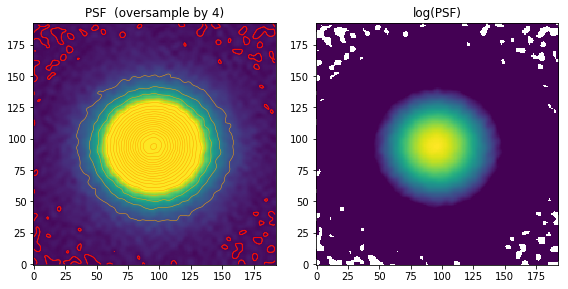

In [8]:
interp4psf = []

ovsmp_factor = 4
ovsmp_bin = 1 / ovsmp_factor

for i, row in enumerate(found):
    cut = cut4psf[i]
    x_orig = np.arange(0, cut.data.shape[1], 1)
    y_orig = np.arange(0, cut.data.shape[0], 1)
    x_ovsmp = np.arange(0, cut.data.shape[1] - 1 + ovsmp_bin, ovsmp_bin)
    y_ovsmp = np.arange(0, cut.data.shape[0] - 1 + ovsmp_bin, ovsmp_bin)
    shift_x = row["xcentroid"] % 1
    shift_y = row["ycentroid"] % 1
    spl = RectBivariateSpline(x_orig - shift_x, y_orig - shift_y, cut.data, kx=3, ky=3, s=0)
    interp_ovsmp = spl(x_ovsmp, y_ovsmp)
    
    interp4psf.append(interp_ovsmp / np.sum(interp_ovsmp))

psf = np.average(np.array(interp4psf), axis=0)
psfspl = RectBivariateSpline(x_ovsmp, y_ovsmp, psf, kx=3, ky=3, s=0)

fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

zimshow(axs[0], psf)
axs[0].contour(psf, levels=20, colors="orange", linewidths=0.5)
axs[0].contour(psf, levels=[0], colors="r", linewidths=1)
axs[0].set_title(f"PSF  (oversample by {ovsmp_factor})")
axs[1].imshow(np.log10(psf), origin="lower", vmin=-4.5)
axs[1].set_title("log(PSF)")

plt.tight_layout()

print("Statistics of the final psf image")
for k, v in yfu.give_stats(psf).items():
    print(f"{k:10s}: {v}")

## Checking the Residuals

/Users/ysbach/anaconda3/lib/python3.6/site-packages/ysphotutilpy-0.0.2.dev0-py3.6.egg/ysphotutilpy/daopsf.py:67: RuntimeWarning: divide by zero encountered in true_divide


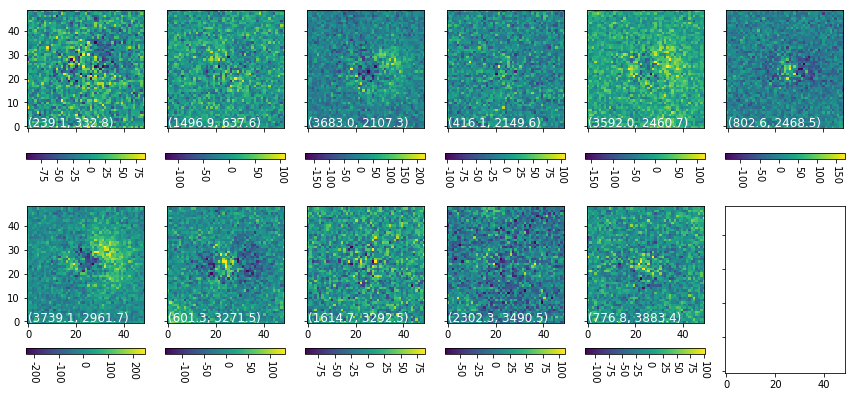

In [9]:
from photutils.psf import FittableImageModel
from astropy.modeling.fitting import LevMarLSQFitter

psfmodel = FittableImageModel(data=psf,
                              oversampling=ovsmp_factor,
                              ikwargs={"degree":[3, 3], "s":0})
ncol = 6
nrow = max(len(found) // ncol + 1, 1)
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 2.8 * nrow), sharex=True, sharey=True)

for i, cut in enumerate(cut4psf):
    # Figure plotting
    irow = i // ncol
    icol = i - irow * ncol
    row = found[i]
    ax = axs[irow, icol]
    fit, pos_fit, _ = ypu.dao_nstar(cut.data, psf=psfmodel, r_fit=fwhm, 
                                    flux_init=row["source_sum"],
                                    full=False)
    
    yy, xx = np.mgrid[:cut.data.shape[1], :cut.data.shape[0]]
    
    im = zimshow(ax, cut.data - fit(xx, yy))
    cb = colorbaring(fig, ax, im)
    
    pos_str = "({:.1f}, {:.1f})".format(*cut.to_original_position(pos_fit))
    ax.text(0, 0, pos_str, fontsize=12, color='w')
    plt.setp(cb.ax.get_xticklabels(),rotation=-90)
    
plt.tight_layout()

In [10]:
psfccd = CCDData(data=psf, unit='adu')
psfccd.header["OVERSAMP"] = (4, "oversampling factor")
psfccd.header["FWHM"] = (fwhm, "The crude FWHM of the stars")
psfccd.header["PSFSIZE"] = (psf_size, "The PSF size")
psfccd.write(LOGPATH / "psf_01.fits", overwrite=True)

## Comparison with ``photutils``

Below is how to construct the [effective PSF by ``photutils``](https://photutils.readthedocs.io/en/stable/epsf.html). 

The ``diff`` is calculated as 

$$ \texttt{diff} = \frac{\mathrm{ePSF~from~photutils} - \mathrm{PSF~in~this~lecture~note}}{\mathrm{PSF~in~this~lecture~note}} $$



In [11]:
from photutils.psf import extract_stars
from photutils import EPSFBuilder
from astropy.visualization import simple_norm
from astropy.nddata import NDData

nddata4psf = []
catalog4psf = []

r_ap = 2 * fwhm
r_in = 4 * fwhm
r_out = 6 * fwhm

for i, row in enumerate(found):
    pos = (row["xcentroid"], row["ycentroid"])
    ap = CAp(positions=pos, r=r_ap)
    an = CAn(positions=pos, r_in=r_in, r_out=r_out)
    phot = ypu.apphot_annulus(ccd=ccd, aperture=ap, annulus=an, 
                              sky_keys=dict(mode_option="MMM"))

    cut = Cutout2D(ccd.data, position=pos, size=2 * psf_size)
    cut_x, cut_y = cut.to_cutout_position(pos)
    cut_skysub = cut.data - phot["msky"][0]

    nddata4psf.append(NDData(cut_skysub.data))    
    catalog4psf.append(Table(data=[[cut_x], [cut_y]],
                             names=["x", "y"]))

stars = extract_stars(nddata4psf, catalog4psf, size=psf_size)
epsf_builder = EPSFBuilder(oversampling=4, 
                           maxiters=100, 
                           progress_bar=False)
epsf, fitted_stars = epsf_builder(stars)
diff = (epsf.data[2:-2, 2:-2] - psf) / psf

Statistics of the (EPSF - PSF) / PSF
N         : 37249
min       : -3915.4366465373446
max       : 23388.465442758992
avg       : 0.37043033502086403
med       : -0.006355387161368216
std       : 127.35265980299462
percentiles: [-18.97692639  18.29634594]
zmin      : -6.266078498157643
zmax      : 6.258211834518341

sigclip avg, med, std: -0.0163, -0.0055, 1.1725


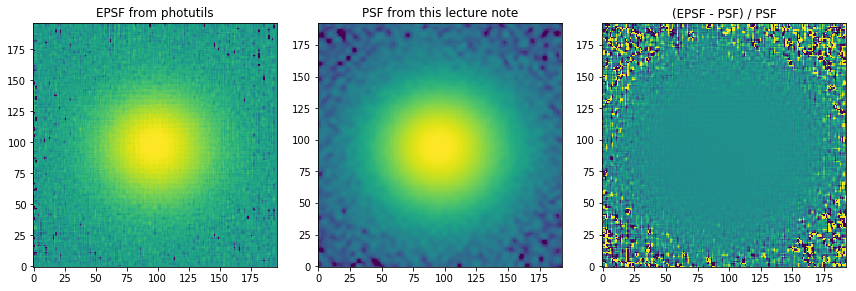

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharex=False, sharey=False, gridspec_kw=None)

axs[0].imshow(epsf.data, norm=simple_norm(epsf.data, 'log', percent=99.), 
              origin='lower', cmap='viridis')
axs[0].set_title("EPSF from photutils")
axs[1].imshow(psf, norm=simple_norm(psf, 'log', percent=99.), 
              origin='lower', cmap='viridis')
axs[1].set_title("PSF from this lecture note")
zimshow(axs[2], diff)
axs[2].set_title("(EPSF - PSF) / PSF")

plt.tight_layout()

print("Statistics of the (EPSF - PSF) / PSF")
for k, v in yfu.give_stats(diff).items():
    print(f"{k:10s}: {v}")

avg, med, std = sigma_clipped_stats(diff, sigma=3, maxiters=5)
print(f"\nsigclip avg, med, std: {avg:.4f}, {med:.4f}, {std:.4f}")

As can be seen from the residual map, the difference is up to factor of -6 to +6 in zscale, and 3-sigma clipped average, median, and standard deviation are -1.6%, -0.5%, and 117%, respectively. 